In [106]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score
import matplotlib.pyplot as plt
import seaborn as sns

In [107]:
matches = pd.read_csv('matches_full.csv', index_col=0)
matches

,date,time,comp,round,day,venue,result,gf,ga,opponent,...,match report,notes,sh,sot,dist,fk,pk,pkatt,season,team
0,2024-08-17,21:30,La Liga,Matchweek 1,Sat,Away,W,2.0,1.0,Valencia,...,Match Report,NaN,17.0,5.0,18.6,1.0,1,1,2025,Barcelona
1,2024-08-24,19:00,La Liga,Matchweek 2,Sat,Home,W,2.0,1.0,Athletic Club,...,Match Report,NaN,13.0,5.0,16.6,0.0,0,0,2025,Barcelona
2,2024-08-27,21:30,La Liga,Matchweek 3,Tue,Away,W,2.0,1.0,Rayo Vallecano,...,Match Report,NaN,22.0,5.0,19.3,1.0,0,0,2025,Barcelona
3,2024-08-31,17:00,La Liga,Matchweek 4,Sat,Home,W,7.0,0.0,Valladolid,...,Match Report,NaN,23.0,11.0,13.7,1.0,0,0,2025,Barcelona
4,2024-09-15,16:15,La Liga,Matchweek 5,Sun,Away,W,4.0,1.0,Girona,...,Match Report,NaN,20.0,9.0,19.1,0.0,0,0,2025,Barcelona
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48,2020-07-05,17:00,La Liga,Matchweek 34,Sun,Home,L,0.0,1.0,Leganés,...,Match Report,NaN,7.0,2.0,18.9,1.0,0,0,2020,Espanyol
49,2020-07-08,22:00,La Liga,Matchweek 35,Wed,Away,L,0.0,1.0,Barcelona,...,Match Report,NaN,11.0,2.0,18.1,1.0,0,0,2020,Espanyol
50,2020-07-12,14:00,La Liga,Matchweek 36,Sun,Home,L,0.0,2.0,Eibar,...,Match Report,NaN,14.0,3.0,20.8,3.0,0,0,2020,Espanyol
51,2020-07-16,21:00,La Liga,Matchweek 37,Thu,Away,L,0.0,1.0,Valencia,...,Match Report,NaN,18.0,6.0,21.3,3.0,0,0,2020,Espanyol


In [108]:
matches.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4318 entries, 0 to 52
Data columns (total 28 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           4318 non-null   object 
 1   time           4318 non-null   object 
 2   comp           4318 non-null   object 
 3   round          4318 non-null   object 
 4   day            4318 non-null   object 
 5   venue          4318 non-null   object 
 6   result         4318 non-null   object 
 7   gf             4318 non-null   float64
 8   ga             4318 non-null   float64
 9   opponent       4318 non-null   object 
 10  xg             4318 non-null   float64
 11  xga            4318 non-null   float64
 12  poss           4318 non-null   float64
 13  attendance     3344 non-null   float64
 14  captain        4318 non-null   object 
 15  formation      4318 non-null   object 
 16  opp formation  4318 non-null   object 
 17  referee        4264 non-null   object 
 18  match report   

###### Feature Engineering

In [109]:
matches['date'] = pd.to_datetime(matches['date'])


In [110]:
matches['venue_code'] = matches['venue'].astype('category').cat.codes

In [111]:
matches['opponent_code'] = matches['opponent'].astype('category').cat.codes

In [112]:
matches['hour'] = matches['time'].str.split(':').str[0].astype(int)

In [113]:
matches['day_code'] = matches['date'].dt.dayofweek

In [114]:
matches['referee_code'] = matches['referee'].astype('category').cat.codes

In [115]:
matches['captain_code'] = matches['captain'].astype('category').cat.codes

In [116]:
matches['xg_diff'] = matches['xg']-matches['xga']

In [117]:
matches['shot_accuracy'] = matches['sot']/matches['sh'].replace(0,np.nan)

In [118]:
matches['shot_accuracy'] = matches['shot_accuracy'].fillna(0)

In [119]:
matches['round_code'] = matches['round'].astype('category').cat.codes

In [120]:
matches['form_code'] = matches['formation'].astype('category').cat.codes

In [121]:
matches['oppform_code'] = matches['opp formation'].astype('category').cat.codes

In [122]:
matches['target'] = (matches['result']=='W').astype('int')

###### Rolling Averages

In [123]:
def rolling_averages(group, cols, new_cols):
    group = group.sort_values('date')
    rolling_stats = group[cols].rolling(3,closed = 'left').mean()
    group[new_cols] = rolling_stats
    return group.dropna(subset=new_cols)

In [124]:
matches.columns

Index(['date', 'time', 'comp', 'round', 'day', 'venue', 'result', 'gf', 'ga',
       'opponent', 'xg', 'xga', 'poss', 'attendance', 'captain', 'formation',
       'opp formation', 'referee', 'match report', 'notes', 'sh', 'sot',
       'dist', 'fk', 'pk', 'pkatt', 'season', 'team', 'venue_code',
       'opponent_code', 'hour', 'day_code', 'referee_code', 'captain_code',
       'xg_diff', 'shot_accuracy', 'round_code', 'form_code', 'oppform_code',
       'target'],
      dtype='object')

In [125]:
cols = ['gf', 'ga','sh', 'sot', 'dist', 'fk', 'pk', 'pkatt','poss','xg_diff', 'shot_accuracy']

new_cols = [f'{c}_rolling' for c in cols]

matches_rolling = matches.groupby('team').apply(lambda x : rolling_averages(x, cols,new_cols))
matches_rolling = matches_rolling.droplevel('team')

matches_rolling.index = range(matches_rolling.shape[0])

###### New feature: Team form (Last 5 matches)

In [126]:
def calculate_team_form(group):
    group = group.sort_values('date')
    group['points'] = group['result'].map({'W':3,'L':0,'D':1})
    group['team_form'] = group['points'].rolling(5,closed='left').mean().fillna(0)
    return group

###### New feature: H-H win percentage

In [127]:
def calculate_head_to_head(df):
    h2h = df.groupby(['team','opponent'])['target'].mean().reset_index()
    h2h.columns = ['team','opponent','h2h_win_pct']
    return df.merge(h2h, on = ['team','opponent'], how = 'left')

In [128]:
matches_rolling = matches_rolling.groupby('team').apply(calculate_team_form)
matches_rolling = matches_rolling.droplevel('team')

matches_rolling.index = range(matches_rolling.shape[0])

In [129]:
matches_rolling = calculate_head_to_head(matches_rolling)
matches_rolling['h2h_win_pct'] = matches_rolling['h2h_win_pct'].fillna(0)

###### Predictors and Train-Test Split

In [130]:
matches.columns

Index(['date', 'time', 'comp', 'round', 'day', 'venue', 'result', 'gf', 'ga',
       'opponent', 'xg', 'xga', 'poss', 'attendance', 'captain', 'formation',
       'opp formation', 'referee', 'match report', 'notes', 'sh', 'sot',
       'dist', 'fk', 'pk', 'pkatt', 'season', 'team', 'venue_code',
       'opponent_code', 'hour', 'day_code', 'referee_code', 'captain_code',
       'xg_diff', 'shot_accuracy', 'round_code', 'form_code', 'oppform_code',
       'target'],
      dtype='object')

In [131]:
predictors = ['venue_code',
       'opponent_code', 'hour', 'day_code', 'referee_code', 'captain_code',
       'xg_diff', 'shot_accuracy', 'round_code', 'form_code', 'oppform_code',
       ]+new_cols+ ['team_form','h2h_win_pct']

train = matches_rolling[matches_rolling['date'] < '2025-01-01']
test = matches_rolling[matches_rolling['date'] > '2025-01-01']

###### Hyperparameter Tuning

In [132]:
param_grid = {
    'n_estimators' : [100,200],
    'max_depth' : [10,20],
    'min_samples_split' :[5,10]
}

In [133]:
rf = RandomForestClassifier(random_state=1)
grid_search = GridSearchCV(rf,param_grid,cv=TimeSeriesSplit(n_splits=3), scoring='precision',n_jobs =-1)
grid_search.fit(train[predictors], train['target'])


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=RandomForestClassifier(random_state=1), n_jobs=-1,
             param_grid={'max_depth': [10, 20], 'min_samples_split': [5, 10],
                         'n_estimators': [100, 200]},
             scoring='precision')

In [134]:
best_rf = grid_search.best_estimator_

In [135]:
best_rf

RandomForestClassifier(max_depth=10, min_samples_split=10, n_estimators=200,
                       random_state=1)

###### Evaluation

In [136]:
preds = best_rf.predict(test[predictors])
accuracy_score(test['target'],preds)

0.7884615384615384

In [137]:
precision_score(test['target'],preds)

0.7692307692307693

In [138]:
confusion_matrix(test['target'],preds)

array([[93,  9],
       [24, 30]])

/Users/shrey/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


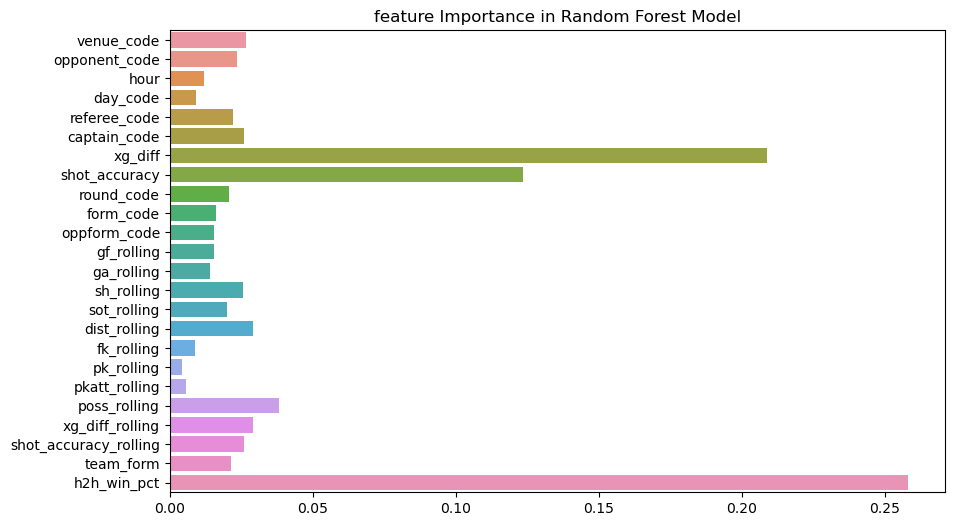

In [139]:
plt.figure(figsize=(10,6))
sns.barplot(x=best_rf.feature_importances_, y=predictors)
plt.title('feature Importance in Random Forest Model')
plt.show()